

<h3 style="text-align: center;"><b>Homework. PyTorch and Fully Connected Networks</b></h3>

You will practice building neural networks using the Pytorch library on several datasets.








In [1]:
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.nn import functional as F

from torch.utils.data import TensorDataset, DataLoader

sns.set(style="darkgrid", font_scale=1.4)

# Part 1. Moons dataset

Let's generate a dataset

In [2]:
X, y = make_moons(n_samples=10000, random_state=42, noise=0.1)

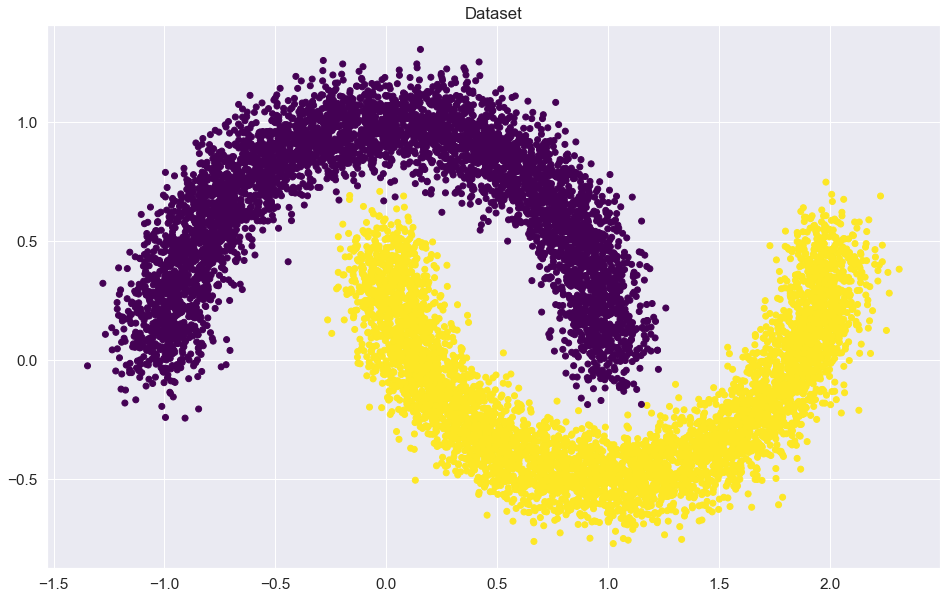

In [3]:
plt.figure(figsize=(16, 10))
plt.title("Dataset")
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis")
plt.show()

Train/test split

In [4]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

### Data loading
In PyTorch, two entities `Dataset` and `DataLoader` are used for data loading.

1. `Dataset` loads each object individually.

2. `DataLoader` groups objects from `Dataset` into batches.

Since our dataset is quite small we will use `TensorDataset`. All we need is to convert from a numpy array to a tensor with type `torch.float32`.

### Exercise (0.5 points). Create tensors with train and test data

In [5]:
X_train_t = torch.from_numpy(X_train).to(torch.float32) # YOUR CODE GOES HERE
y_train_t = torch.from_numpy(y_train).to(torch.float32) # YOUR CODE GOES HERE 
X_val_t = torch.from_numpy(X_val).to(torch.float32) # YOUR CODE GOES HERE 
y_val_t = torch.from_numpy(y_val).to(torch.float32) # YOUR CODE GOES HERE 

Create `Dataset` и `DataLoader`. 

In [6]:
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_dataloader = DataLoader(train_dataset, batch_size=128)
val_dataloader = DataLoader(val_dataset, batch_size=128)

### Exercise (1 point). Implementing Logistic Regression

You need to write a PyTorch module that implements $logits = XW + b$, where $W$ and $b$ are parameters (`nn.Parameter`) of the model. In other words, here we implement the `nn.Linear` module ourselves (in this exercise, its use is prohibited). Initialize the weights with a normal distribution (`torch.randn`).

In [7]:
class LinearRegression(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(in_features))
        self.bias = bias
        if bias:
            self.bias_term = nn.Parameter(torch.randn(out_features)) # YOUR CODE GOES HERE

    def forward(self, x):
        x =  x @ self.weights # YOUR CODE GOES HERE
        if self.bias:
            x += self.bias_term # YOUR CODE GOES HERE
        return x

In [8]:
linear_regression = LinearRegression(2, 1)
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(linear_regression.parameters(), lr=0.05)
model = nn.Sequential(linear_regression)

### Train loop

Here is a pseudocode to help you figure out what's going on during training

```python
for epoch in range(max_epochs):  # <----------- iterate over the dataset several times
    for x_batch, y_batch in dataset:  # <------ iterate over the dataset. Since we use SGD and not GD, we take batches of a given size
        optimizer.zero_grad()  # <------------- reset model gradients
        outp = model(x_batch)  # <------------- get "logits" from the model
        loss = loss_func(outp, y_batch)  # <--- calculate "loss" for logistic regression
        loss.backward()  # <------------------- find gradients
        optimizer.step()  # <------------------ do the gradient descent step
        if convergence:  # <------------------- in case of convergence exit the cycle
            break
```

In the code below `accuracy` and `loss` logging was added.

### Exercise (1 point). Implementation of the training cycle

In [9]:
tol = 1e-3
losses = []
max_epochs = 100
prev_weights = torch.zeros_like(linear_regression.weights)
stop_it = False
for epoch in range(max_epochs):
    for it, (X_batch, y_batch) in enumerate(train_dataloader):
        optimizer.zero_grad()
        outp = model(X_batch) # YOUR CODE. Use linear_regression to get outputs
        loss = loss_function(outp, y_batch) # YOUR CODE. Compute loss
        loss.backward()
        losses.append(loss.detach().flatten()[0])
        optimizer.step()
        probabilities = torch.sigmoid(outp) # YOUR CODE. Compute probabilities
        preds = (probabilities > 0.5).type(torch.long)
        batch_acc = (preds.flatten() == y_batch).type(torch.float32).sum() / y_batch.size(0)
        
        if (it + epoch * len(train_dataloader)) % 100 == 0:
            print(f"Iteration: {it + epoch * len(train_dataloader)}\nBatch accuracy: {batch_acc}")
        current_weights = linear_regression.weights.detach().clone()
        if (prev_weights - current_weights).abs().max() < tol:
            print(f"\nIteration: {it + epoch * len(train_dataloader)}.Convergence. Stopping iterations.")
            stop_it = True
            break
        prev_weights = current_weights
    if stop_it:
        break

Iteration: 0
Batch accuracy: 0.6328125
Iteration: 100
Batch accuracy: 0.84375
Iteration: 200
Batch accuracy: 0.828125
Iteration: 300
Batch accuracy: 0.921875
Iteration: 400
Batch accuracy: 0.890625
Iteration: 500
Batch accuracy: 0.90625

Iteration: 578.Convergence. Stopping iterations.


**Question (0.33 points).** How many iterations did it take for the algorithm to converge?

**Answer:** 519 iterations

### Visualize the results


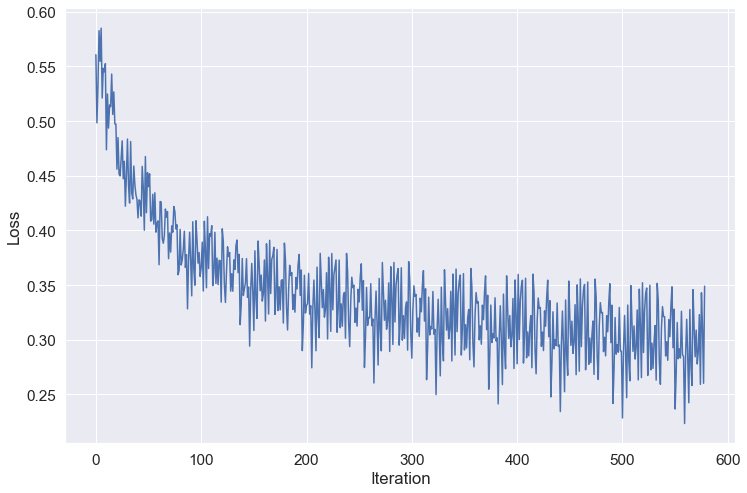

In [10]:
plt.figure(figsize=(12, 8))
plt.plot(range(len(losses)), losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

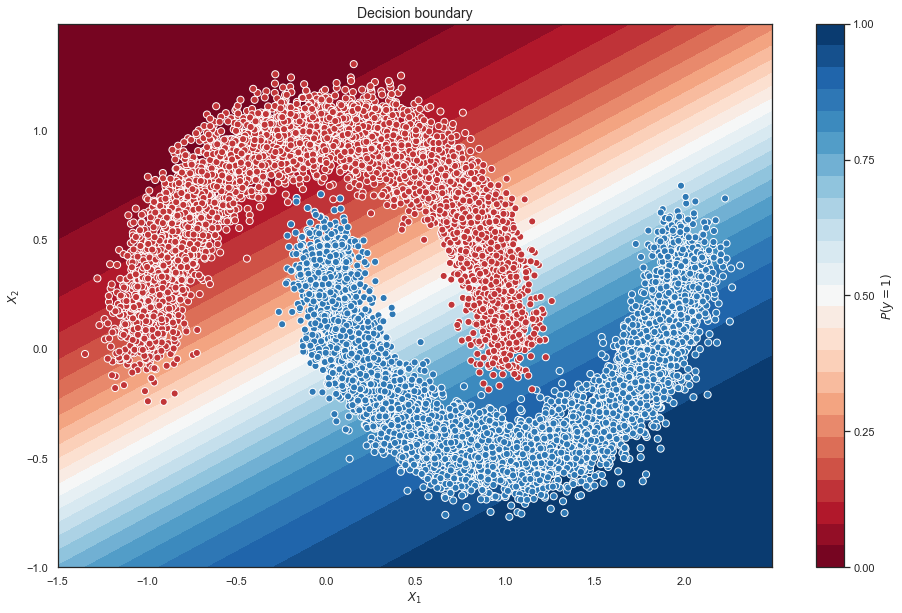

In [11]:
import numpy as np

sns.set(style="white")

xx, yy = np.mgrid[-1.5:2.5:.01, -1.:1.5:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
batch = torch.from_numpy(grid).type(torch.float32)
with torch.no_grad():
    probs = torch.sigmoid(linear_regression(batch).reshape(xx.shape))
    probs = probs.numpy().reshape(xx.shape)

f, ax = plt.subplots(figsize=(16, 10))
ax.set_title("Decision boundary", fontsize=14)
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X[100:,0], X[100:, 1], c=y[100:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(xlabel="$X_1$", ylabel="$X_2$")
plt.show()

### Exercise (1 point). Implement predict and calculate accuracy on test.

In [12]:
@torch.no_grad()
def predict(dataloader, model):
    model.eval()
    predictions = np.array([])
    for x_batch, _ in dataloader:
        outp = model(x_batch)
        probs = torch.sigmoid(outp)
        preds = (probs > 0.5).type(torch.long) #YOUR CODE. Compute predictions
        predictions = np.hstack((predictions, preds.numpy().flatten()))
    return predictions.flatten()

In [13]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_val, predict(val_dataloader, model))
accuracy# YOUR CODE. Compute total accuracy

0.8676

**Question (0.33 points)**

What `accuracy` is obtained after training?

**Answer:** 87.64%

# Part 2. MNIST Dataset
The MNIST dataset contains handwritten numbers. Let's load the dataset and create DataLoaders.

In [14]:
import os
from torchvision import transforms as tfs
from torchvision.datasets import MNIST

data_tfs = tfs.Compose([
    tfs.ToTensor(),
    tfs.Normalize((0.5), (0.5))
])

# install for train and test
root = './'
train_dataset = MNIST(root, train=True,  transform=data_tfs, download=True)
val_dataset  = MNIST(root, train=False, transform=data_tfs, download=True)

train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=128, 
                                           shuffle=True) # YOUR CODE GOES HERE
valid_dataloader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                          batch_size=128, 
                                          shuffle=False)  # YOUR CODE GOES HERE

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST\raw\train-images-idx3-ubyte.gz to ./MNIST\raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST\raw\train-labels-idx1-ubyte.gz to ./MNIST\raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST\raw\t10k-images-idx3-ubyte.gz to ./MNIST\raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST\raw\t10k-labels-idx1-ubyte.gz to ./MNIST\raw



## Part 2.1. Fully Connected Neural Networks
We start with a fully connected neural network.

In [15]:
class Identical(nn.Module):
    def forward(self, x):
        return x

### Exercise (1 point). Simple fully connected neural network

Create a fully connected neural network using the Sequential class. The network consists of:
* Flattening a matrix into a vector (nn.Flatten);
* Two hidden layers of 128 neurons with nn.ELU activation;
* Output layer with 10 neurons.

Set the training loss (cross-entropy).


In [16]:
activation = nn.ELU()
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 128),
    activation,
    nn.Linear(128, 128),
    activation,
    nn.Linear(128, 10)
    #YOUR CODE. Add layers to your sequential class
)

In [17]:
criterion = nn.CrossEntropyLoss() #YOUR CODE. Select a loss function
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

In [18]:
device = "cuda" if torch.cuda.is_available() else "cpu"

### Train loop

The code below will work for 80% of tasks you can face.

```python
for epoch in range(max_epochs):  # <--------------- iterate over the dataset several times
    for k, dataloader in loaders.items():  # <----- several dataloaders for train/valid/test
        for x_batch, y_batch in dataloader:  # <--- iterate over the dataset. Since we use SGD and not GD, we take batches of a given size
            if k == "train":
                model.train()  # <------------------ put the model into train mode
                optimizer.zero_grad()  # <--------- reset model gradients
                outp = model(x_batch)
                loss = criterion(outp, y_batch) # <-calculate "loss" for logistic regression
                loss.backward()  # <--------------- find gradients
                optimizer.step()  # <-------------- do the gradient descent step
            else:  # <----------------------------- test/eval
                model.eval()  # <------------------ put the model in eval mode
                with torch.no_grad():  # <--------- DO NOT find gradients
                    outp = model(x_batch)  # <------------- get "logits" from the model
            count_metrics(outp, y_batch)  # <-------------- find metrics
```

### Exercise (1.5 points). Complete the learning cycle.

In [32]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            if k == "train":
                model.train()
                optimizer.zero_grad()
                outp = model(x_batch)
                 # YOUR CODE. Set model to ``train`` mode and calculate outputs. Don't forget zero_grad!
            else:
                model.eval() 
                with torch.no_grad():
                    outp = model(x_batch)
                    # YOUR CODE. Set model to ``eval`` mode and calculate outputs
            preds = outp.argmax(-1)
            correct = int(torch.sum(preds==y_batch)) # YOUR CODE GOES HERE
            all =  y_batch.shape[0]  # YOUR CODE GOES HERE
            epoch_correct += correct
            epoch_all += all
            if k == "train":
                loss = criterion(outp, y_batch)
                loss.backward() 
                optimizer.step() 
                # YOUR CODE. Calculate gradients and make a step of your optimizer
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)


Epoch: 1
Loader: train. Accuracy: 0.8836666666666667
Loader: valid. Accuracy: 0.9397
Epoch: 2
Loader: train. Accuracy: 0.9482333333333334
Loader: valid. Accuracy: 0.9538
Epoch: 3
Loader: train. Accuracy: 0.9627333333333333
Loader: valid. Accuracy: 0.967
Epoch: 4
Loader: train. Accuracy: 0.9712166666666666
Loader: valid. Accuracy: 0.97
Epoch: 5
Loader: train. Accuracy: 0.97495
Loader: valid. Accuracy: 0.9677
Epoch: 6
Loader: train. Accuracy: 0.9779666666666667
Loader: valid. Accuracy: 0.9733
Epoch: 7
Loader: train. Accuracy: 0.9816333333333334
Loader: valid. Accuracy: 0.9739
Epoch: 8
Loader: train. Accuracy: 0.9836833333333334
Loader: valid. Accuracy: 0.9732
Epoch: 9
Loader: train. Accuracy: 0.9853666666666666
Loader: valid. Accuracy: 0.9761
Epoch: 10
Loader: train. Accuracy: 0.9871333333333333
Loader: valid. Accuracy: 0.9758


### Exercise (1.5 points). Different activation functions.
Try different activation functions. For each activation function, count the validation accuracy array. It is better to implement this as a function that takes an activation as input and receives an array of accuracies.

In [33]:
elu_accuracy = accuracy["valid"]

In [34]:
# YOUR CODE. Do the same thing with other activations (it's better to wrap into a function that returns a list of accuracies)
def test_activation_function(activation):
    model = nn.Sequential(
        nn.Flatten(),
        nn.Linear(784, 128),
        activation,
        nn.Linear(128, 128),
        activation,
        nn.Linear(128, 10)
        #YOUR CODE. Add layers to your sequential class
    )
    criterion = nn.CrossEntropyLoss() #YOUR CODE. Select a loss function
    optimizer = torch.optim.Adam(model.parameters())

    loaders = {"train": train_dataloader, "valid": valid_dataloader}
    
    max_epochs = 10
    accuracy = {"train": [], "valid": []}
    for epoch in range(max_epochs):
        for k, dataloader in loaders.items():
            epoch_correct = 0
            epoch_all = 0
            for x_batch, y_batch in dataloader:
                if k == "train":
                    model.train()
                    optimizer.zero_grad()
                    outp = model(x_batch)
                     # YOUR CODE. Set model to ``train`` mode and calculate outputs. Don't forget zero_grad!
                else:
                    model.eval() 
                    with torch.no_grad():
                        outp = model(x_batch)
                        # YOUR CODE. Set model to ``eval`` mode and calculate outputs
                preds = outp.argmax(-1)
                correct = int(torch.sum(preds==y_batch)) # YOUR CODE GOES HERE
                all =  y_batch.shape[0]  # YOUR CODE GOES HERE
                epoch_correct += correct
                epoch_all += all
                if k == "train":
                    loss = criterion(outp, y_batch)
                    loss.backward() 
                    optimizer.step() 
                    # YOUR CODE. Calculate gradients and make a step of your optimizer
#            if k == "train":
#                print(f"Epoch: {epoch+1}")
#            print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
            accuracy[k].append(epoch_correct/epoch_all)
    return accuracy
    #YOUR CODE

In [35]:
plain_accuracy = test_activation_function(Identical())["valid"]
relu_accuracy = test_activation_function(nn.ReLU())["valid"]
leaky_relu_accuracy = test_activation_function(nn.LeakyReLU())["valid"]

### Accuracy
Let's plot an accuracy/epoch graph for each activation function.

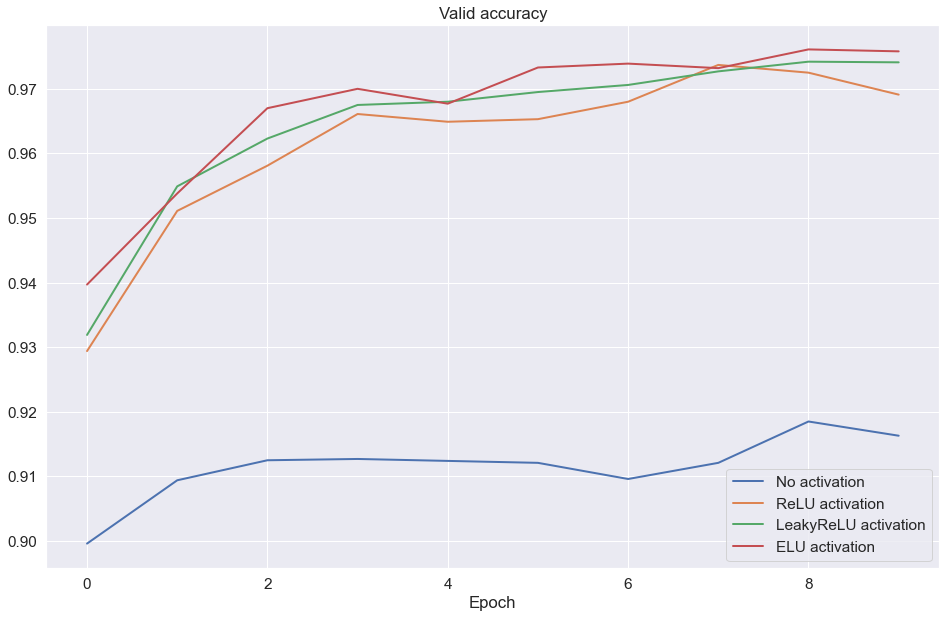

In [38]:
sns.set(style="darkgrid", font_scale=1.4)

plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), plain_accuracy, label="No activation", linewidth=2)
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

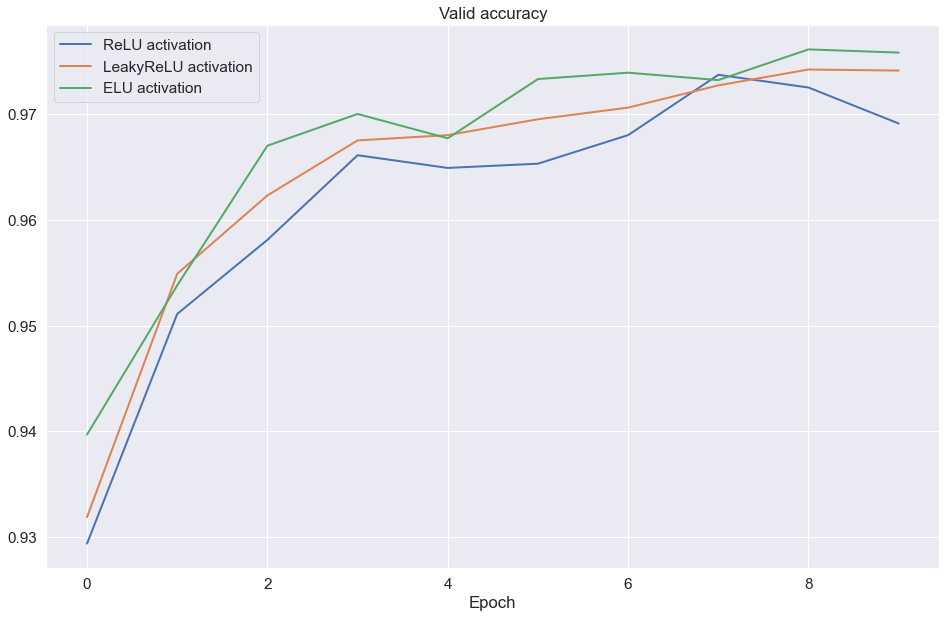

In [39]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Question. (0.33 points)** Which of the activation functions showed the highest `accuracy` by the end of the training?

**Answer:**

In [ ]:
ELU activation